In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dating-full.csv")[:6500]

## 1. Preprocessing 

In [3]:
# first preprocessing the first two parts
func_dict = {
    1: lambda x: x[0] == '"' or x[0] == "'",
    2: lambda x: any(y.isupper() for y in x),   
}
def race_f(x):
    if func_dict[1](x):
        return x[1:-1]
    else:
        return x
modi_dict = {
    1: race_f,
    2: lambda x: x.lower(),   
}
str_dict = {
    1: "Quotes removed from {} cells.",
    2: "Standardized {} cells to lower case.",  
}
def cond(name, index):
    return df[name].apply(func_dict[index])
def modify(name, index):
    df[name] = df[name].apply(modi_dict[index])

def handle_pre(name, index):
    ret = np.sum(cond(name, index))
    modify(name, index)
    return ret

s_ = handle_pre("race", 1)
s_ += handle_pre("race_o", 1)
s_ += handle_pre("field", 1)
# print(str_dict[1].format(s_))
s_ = handle_pre("field", 2)
# print(str_dict[2].format(s_))

In [4]:
# then label encoding
str_lbenc = "Mapped vector for {} in column {}: {}."
value_set = {
    "female": "gender",
    "Black/African American": "race",
    "Other": "race_o",
    "economics": "field",
}
def handle_enc(name):
    Set = sorted(set(df[name])) # Alphabetically sorted
    Len = len(Set)
    Dict = {}
    for index, value in enumerate(Set):
        Dict[value] = np.zeros(Len).astype(np.int32)
        Dict[value][index] += 1
        if value in value_set and value_set[value]==name:
            print(str_lbenc.format(value, name, Dict[value]))
    # df[name] = df[name].apply(lambda x:Dict[x])
    if name == "field":
        Len = 210
    f = open(f"tmp/{name}.txt", "w")
    f.write(f"{Len}")
    return pd.get_dummies(df, columns=[name])
    
df = handle_enc("gender")
df = handle_enc("race")
df = handle_enc("race_o")
df = handle_enc("field")

Mapped vector for female in column gender: [1 0].
Mapped vector for Black/African American in column race: [0 1 0 0 0].
Mapped vector for Other in column race_o: [0 0 0 0 1].
Mapped vector for economics in column field: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0].


In [5]:
# finally normalization
str_nor = "Mean of {}: {:0.2f}."
psop = [
    "attractive_important", 
    "sincere_important", 
    "intelligence_important", 
    "funny_important", 
    "ambition_important", 
    "shared_interests_important"
]
psoo = [
    "pref_o_attractive", 
    "pref_o_sincere", 
    "pref_o_intelligence", 
    "pref_o_funny", 
    "pref_o_ambitious", 
    "pref_o_shared_interests"
]
rofp = [
    "attractive_partner", 
    "sincere_partner", 
    "intelligence_parter", 
    "funny_partner", 
    "ambition_partner", 
    "shared_interests_partner"
]

def handle_nor(LIST):
    df[LIST] = df[LIST].apply(lambda x: x/np.sum(x), axis = 1)

handle_nor(psop)
handle_nor(psoo)
# [print(str_nor.format(name, np.mean(df[name]))) for name in psop + psoo]
None

In [6]:
# put the decision to the final column
df = df[list(set(df.columns) - set(['decision'])) + ['decision']]

### Save to file

In [7]:
def build_tr_te_utd():
    test_set = df.sample(frac=0.2, random_state=25)
    binned_data = pd.read_csv("dating-binned.csv", index_col=[0])[:6500]
    train_set = df.loc[list(set(df.index) - set(test_set.index))]
    train_binned = binned_data.loc[list(set(df.index) - set(test_set.index))]
    train_set.to_csv("trainingSet.csv")
    train_binned.to_csv("trainingBinned.csv")
    test_set.to_csv("testSet.csv")
build_tr_te_utd()

## 2. LR and SVM

In [8]:
feature_space_size = df.shape[1] - 1
def lr(trainingSet, testSet, if_p = True):
    # define vars
    Lambda, learning_rate, max_iter, threshold = 1e-2, 1e-2, 500, 1e-6
    theta = np.zeros(feature_space_size + 1) # one more for the constant

    # forward and backward functions
    def forward(data):
        return 1 / (
                    1 + np.exp(
                        -(
                            data 
                             @ 
                            theta.reshape(-1, 1)
                        ).reshape(-1)
                    )
                )
    def Grad(data, labels, now_th):
        return (
                data.T 
                 @ 
                (
                    forward(data) 
                     - 
                    labels
                ).reshape(-1, 1)
            ).reshape(-1) / labels.shape[0] + Lambda * now_th # Second is the regulation term 
                            

    # X, y; split
    trX, tr_y = trainingSet[:, :-1], trainingSet[:, -1]
    teX, te_y = testSet[:, :-1], testSet[:, -1]
        # add one more full 1 column
    one_col_tr = np.ones(trX.shape[0]).reshape(-1, 1)
    one_col_te = np.ones(teX.shape[0]).reshape(-1, 1)
    trX = np.concatenate((trX, one_col_tr), axis=1)
    teX = np.concatenate((teX, one_col_te), axis=1)
    
    # TRAIN 
    for epoch in range(max_iter):
        delta = learning_rate * Grad(trX, tr_y, theta)
        if np.dot(delta, delta) < threshold:
            break
        theta -= delta

    # print(np.dot(theta, theta))

    # TEST on TRAIN
    predict = forward(trX) + 0.5
    acc = np.sum(predict.astype(int) == tr_y.astype(int)) / predict.shape[0]
    if if_p:
        print(f"Training Accuracy LR: {acc}")

    # TEST on TEST
    predict = forward(teX) + 0.5
    acc = np.sum(predict.astype(int) == te_y.astype(int)) / predict.shape[0]
    if if_p:
        print(f"Testing Accuracy LR: {acc}")

    return acc

In [9]:
def svm(trainingSet, testSet, if_p = True):
    # define vars
    Lambda, learning_rate, max_iter, threshold = 1e-2, 0.5, 500, 1e-6
    theta = np.zeros(feature_space_size + 1) # one more for the constant

    # forward and backward functions
    def forward(data):
        return  np.sign(
                    data 
                     @ 
                    theta.reshape(-1, 1)
                ).reshape(-1)
    def Grad(data, labels, now_th):
        return (
                -(
                    labels 
                     * 
                    (
                        data 
                         @ 
                        now_th.reshape(-1, 1)
                    ).reshape(-1) 
                     < 
                    1.0
                ).astype(np.float32).reshape(1, -1) 
                 @ 
                (
                    data 
                     * 
                    labels.reshape(-1, 1)
                )
               ).reshape(-1) / labels.shape[0] + Lambda * now_th
                            

    # X, y; split
    trX, tr_y = trainingSet[:, :-1], trainingSet[:, -1]
    teX, te_y = testSet[:, :-1], testSet[:, -1]
        # add one more full 1 column
    one_col_tr = np.ones(trX.shape[0]).reshape(-1, 1)
    one_col_te = np.ones(teX.shape[0]).reshape(-1, 1)
    trX = np.concatenate((trX, one_col_tr), axis=1)
    teX = np.concatenate((teX, one_col_te), axis=1)
        # transform 0,1 -> -1,1
    tr_y = tr_y * 2 - 1
    te_y = te_y * 2 - 1
    
    # TRAIN 
    for epoch in range(max_iter):
        delta = learning_rate * Grad(trX, tr_y, theta)
        if np.dot(delta, delta) < threshold:
            break
        theta -= delta

    # print(np.dot(theta, theta))

    # TEST on TRAIN
    predict = forward(trX)
    acc = np.sum(predict.astype(int) == tr_y.astype(int)) / predict.shape[0]
    if if_p:
        print(f"Training Accuracy LR: {acc}")
    
    # TEST on TEST
    predict = forward(teX)
    acc = np.sum(predict.astype(int) == te_y.astype(int)) / predict.shape[0]
    if if_p:
        print(f"Testing Accuracy LR: {acc}")

    return acc

In [10]:
def lrsvm(trainingDataFilename, testDataFilename, modelIdx):
    Train = np.array(pd.read_csv(trainingDataFilename, index_col=[0]), dtype = np.float32)
    Test = np.array(pd.read_csv(testDataFilename, index_col=[0]), dtype = np.float32)
    if modelIdx == 1:
        lr(Train, Test)
    elif modelIdx == 2:
        svm(Train, Test)
    else:
        print("Wrong modelIdx!")

In [11]:
lrsvm("trainingSet.csv", "testSet.csv", 1)

Training Accuracy LR: 0.6601923076923077
Testing Accuracy LR: 0.6561538461538462


In [12]:
lrsvm("trainingSet.csv", "testSet.csv", 2)

Training Accuracy LR: 0.5605769230769231
Testing Accuracy LR: 0.5538461538461539


## 3. Learning Curve & Performance

In [13]:
class NBC: # reuse what in hw2
    def __init__(self, col_names, bin_size):
        self.c2d = { # learned conditional prob
            col: []
            for col in col_names
        }
        self.c2all_set = {
            col: np.arange(bin_size)
            for col in col_names
        }
        self.y = [] # learned prob

        for name in ("gender", "race", "race_o", "field"):
            self.c2all_set[name] = np.arange(int(open(f"tmp/{name}.txt", "r").read()))
        self.c2all_set["samerace"] = np.arange(2)
        
    def fit(self, data):
        self.y = data["decision"].value_counts(normalize=True).reindex([0, 1], fill_value=0) 
        # nearly impossible to have all 0 or 1, but still need to handle
        for col in self.c2d:
            self.c2d[col] = (
                data[data["decision"] == 0][col].value_counts(normalize=True).reindex(self.c2all_set[col], fill_value=0),
                data[data["decision"] == 1][col].value_counts(normalize=True).reindex(self.c2all_set[col], fill_value=0),
            )
            # print(self.c2d[col][0])
            # print(self.c2d[col][1])
        
    def test(self, data, name, ban_print):
        tag_y = np.array(data["decision"])
        predict_y = np.array(self.y).reshape(-1, 1)
        for col in self.c2d:
            # firstly broadcast, then element-wise multiply
            predict_y = predict_y * np.array((
                                      self.c2d[col][0][np.array(data[col])], 
                                      self.c2d[col][1][np.array(data[col])]
                                    )) 
        predict_y = np.transpose(predict_y, (1, 0)).argmax(axis = 1)
        acc = np.sum(tag_y == predict_y) / tag_y.shape[0]
        if ban_print == 0:
            print(f"{name} Accuracy:  {acc}")
        return acc

In [14]:
train_4_3 = pd.read_csv("trainingSet.csv", index_col=[0])
train_4_bin = pd.read_csv("trainingBinned.csv", index_col=[0])
train_4_3 = train_4_3.sample(frac=1, random_state=18) # reshuffle

In [15]:
acn, acl, acs, ern, erl, ers = [], [], [], [], [], []
frac_ = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
for Frac in frac_:
    nbc_ar, lr_ar, svm_ar = [], [], []
    for IDX in range(10):
        test_idx, train_idx = train_4_3.index[520*IDX:520*IDX+520], list(train_4_3.index[:520*IDX]) + list(train_4_3.index[520*IDX+520:])
        test_ub, test_b = train_4_3.loc[test_idx], train_4_bin.loc[test_idx]
        train_ub, train_b = train_4_3.loc[train_idx], train_4_bin.loc[train_idx]
        train_ub = train_ub.sample(frac = Frac, random_state = 32)
        train_b = train_b.loc[train_ub.index]
        NBCModel = NBC(set(train_4_bin.columns) - set(["decision"]), 5)
        # FIT
        NBCModel.fit(train_b)
        acc_nbc = NBCModel.test(test_b, "Testing", ban_print = 1)
        acc_lr = lr(np.array(train_ub, dtype=np.float32), np.array(test_ub, dtype=np.float32), False)
        acc_svm = svm(np.array(train_ub, dtype=np.float32), np.array(test_ub, dtype=np.float32), False)
        # Append
        nbc_ar.append(acc_nbc)
        lr_ar.append(acc_lr)
        svm_ar.append(acc_svm)
    # Compute the sterr
    sterr_nbc = np.std(nbc_ar) / np.sqrt(10)
    sterr_lr = np.std(lr_ar) / np.sqrt(10)
    sterr_svm = np.std(svm_ar) / np.sqrt(10)
    # Compute the average acc
    avacc_nbc = np.mean(nbc_ar)
    avacc_lr = np.mean(lr_ar)
    avacc_svm = np.mean(svm_ar)

    # Print
    print(Frac, avacc_nbc, avacc_lr, avacc_svm)

    # add to present lists
    acn.append(avacc_nbc)
    acl.append(avacc_lr)
    acs.append(avacc_svm)
    ern.append(sterr_nbc)
    erl.append(sterr_lr)
    ers.append(sterr_svm)

0.025 0.6084615384615384 0.6692307692307693 0.5546153846153846
0.05 0.6299999999999999 0.6588461538461539 0.5546153846153846
0.075 0.6588461538461539 0.6694230769230769 0.5603846153846154
0.1 0.6736538461538462 0.6753846153846154 0.5638461538461538
0.15 0.6976923076923076 0.6730769230769231 0.5676923076923076
0.2 0.7165384615384615 0.6665384615384615 0.5682692307692307


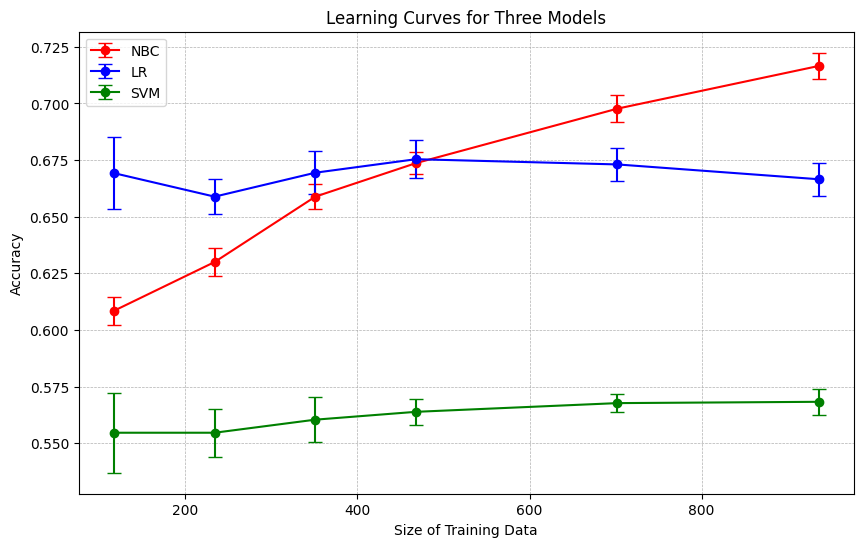

In [16]:
plt.figure(figsize=(10, 6))
frac_ = (np.array(frac_) * 520 * 9)
plt.errorbar(frac_, acn, yerr=ern, label="NBC", marker='o', capsize=5, linestyle='-', color = 'r')
plt.errorbar(frac_, acl, yerr=erl, label="LR", marker='o', capsize=5, linestyle='-', color = 'b')
plt.errorbar(frac_, acs, yerr=ers, label="SVM", marker='o', capsize=5, linestyle='-', color = 'g')

plt.xlabel("Size of Training Data")
plt.ylabel("Accuracy")
plt.title("Learning Curves for Three Models")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Hypothesis
- this problem may not be linearly separable, but not so complicated.

## Test and Proof
- Comparing performance between NBC and SVM.
- We can find the acc of SVM never exceed 57.5%, while it of NBC continue to increase obviously with our putting more data to train. This is enough to show my hypothesis since NBC is not a strong model.